In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage,interpolate

from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
import time
import pandas as pd
import seaborn as sns

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


In [2]:
from myfunction import*

In [3]:
opt_contrast = load('clamato/opt_contrast3.npy')

In [4]:
wiener_contrast = fromfile('clamato/map_2017_v4.bin').reshape(60,48,-1)
opt_contrast = load('clamato/opt_contrast3.npy')

In [101]:
coords_wiener = load('clamato/cla_coords_wiener0.1.npy')
r_wiener = load('clamato/cla_r_wiener0.1.npy')

In [102]:
coords_opt = load('clamato/cla_coords_opt0.1.npy')
r_opt = load('clamato/cla_r_opt0.1.npy')

In [131]:
void_frac(coords_opt,r_opt,[876,48,60])

run time: 10.025809288024902


0.1945737049443092

In [60]:
void_frac(coords_wiener,r_wiener,[60,48,876])

run time: 8.464563846588135


0.2075767419564313

In [8]:
void_cla = loadtxt('clamato/voids_clamato2017_v4.dat',skiprows=4)

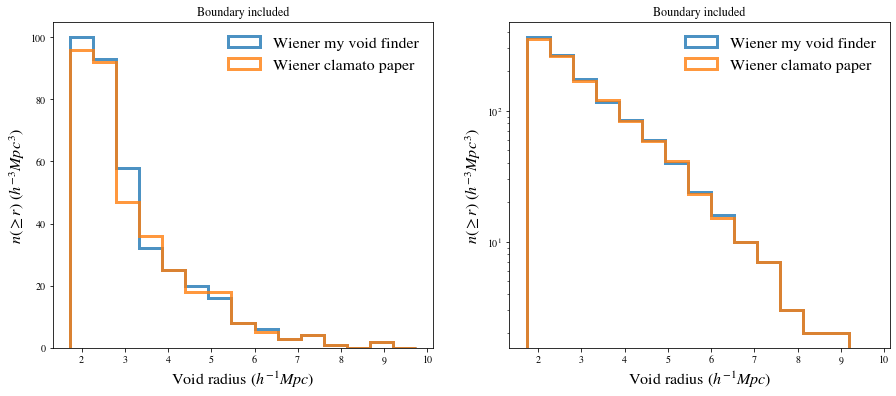

In [119]:
bins = linspace(2,10,16)
figure(figsize=(15,6))
hist_list = {'bins':bins,'align':'left','histtype':'step',
             'density':False,'cumulative':False,'alpha':0.8,'linewidth':3}
subplot(121)
hist(r_wiener[r_wiener>4]/2,label='Wiener my void finder',**hist_list)
hist(void_cla[:,3],label='Wiener clamato paper',**hist_list)

legend(frameon=False,prop={'family':'STIXGeneral','size':16})
ylabel(r'$n(\geq r)\ (h^{-3}Mpc^3)$',fontsize=16)
xlabel('Void radius $(h^{-1}Mpc)$',fontsize=16)
title('Boundary included')

subplot(122)
hist_list2 = {'bins':bins,'align':'left','histtype':'step',
             'density':False,'log':False,'cumulative':-1,'alpha':0.8,'linewidth':3}
hist(r_wiener[r_wiener>4]/2,label='Wiener my void finder',**hist_list2)
hist(void_cla[:,3],label='Wiener clamato paper',**hist_list2)

legend(frameon=False,prop={'family':'STIXGeneral','size':16})
ylabel(r'$n(\geq r)\ (h^{-3}Mpc^3)$',fontsize=16)
xlabel('Void radius $(h^{-1}Mpc)$',fontsize=16)
title('Boundary included',fontname='STIXGeneral')
yscale('log')

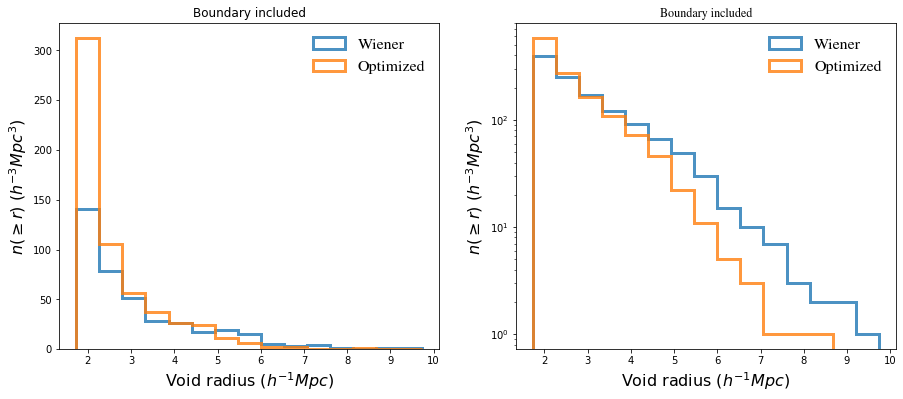

In [175]:
bins = linspace(2,10,16)
figure(figsize=(15,6))
hist_list = {'bins':bins,'align':'left','histtype':'step',
             'density':False,'cumulative':False,'alpha':0.8,'linewidth':3}
subplot(121)
hist(r_wiener/2,label='Wiener',**hist_list)
hist(r_opt/2,label='Optimized',**hist_list)
legend(frameon=False,prop={'family':'STIXGeneral','size':16})
ylabel(r'$n(\geq r)\ (h^{-3}Mpc^3)$',fontsize=16)
xlabel('Void radius $(h^{-1}Mpc)$',fontsize=16)
title('Boundary included')

subplot(122)
hist_list2 = {'bins':bins,'align':'left','histtype':'step',
             'density':False,'log':False,'cumulative':-1,'alpha':0.8,'linewidth':3}
hist(r_wiener/2,label='Wiener',**hist_list2)
hist(r_opt/2,label='Optimized',**hist_list2)
legend(frameon=False,prop={'family':'STIXGeneral','size':16})
ylabel(r'$n(\geq r)\ (h^{-3}Mpc^3)$',fontsize=16)
xlabel('Void radius $(h^{-1}Mpc)$',fontsize=16)
title('Boundary included',fontname='STIXGeneral')
yscale('log')


In [153]:
_,r_opt_re = remove_bound(coords_opt,r_opt,[876,48,60])
_,r_wiener_re = remove_bound(coords_wiener,r_wiener,[60,48,876])

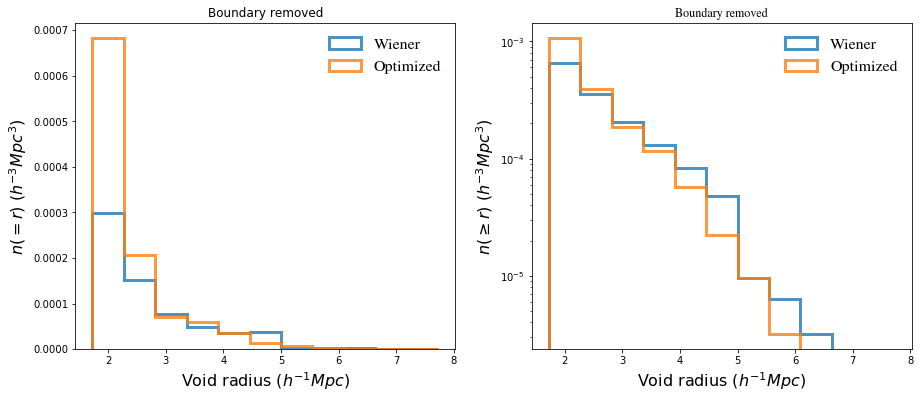

In [171]:
bins = linspace(2,8,12)
figure(figsize=(15,6))
hist_list = {'bins':bins,'align':'left','histtype':'step',
             'density':False,'cumulative':False,'alpha':0.8,'linewidth':3}
subplot(121)
hist(r_wiener_re/2,label='Wiener',**hist_list,weights=[8/(876*48*60)]*len(r_wiener_re))
hist(r_opt_re/2,label='Optimized',**hist_list,weights=[8/(876*48*60)]*len(r_opt_re))
legend(frameon=False,prop={'family':'STIXGeneral','size':16})
ylabel(r'$n(=r)\ (h^{-3}Mpc^3)$',fontsize=16)
xlabel('Void radius $(h^{-1}Mpc)$',fontsize=16)
title('Boundary removed')

subplot(122)
hist_list2 = {'bins':bins,'align':'left','histtype':'step',
             'density':False,'log':False,'cumulative':-1,'alpha':0.8,'linewidth':3}
hist(r_wiener_re/2,label='Wiener',**hist_list2,weights=[8/(876*48*60)]*len(r_wiener_re))
hist(r_opt_re/2,label='Optimized',**hist_list2,weights=[8/(876*48*60)]*len(r_opt_re))
legend(frameon=False,prop={'family':'STIXGeneral','size':16})
ylabel(r'$n(\geq r)\ (h^{-3}Mpc^3)$',fontsize=16)
xlabel('Void radius $(h^{-1}Mpc)$',fontsize=16)
title('Boundary removed',fontname='STIXGeneral')
yscale('log')

In [14]:
%%time
x_wiener,y_wiener,err_wiener=void_profile_mp(coords_wiener[r_wiener>=10],r_wiener[r_wiener>=10],wiener_contrast,[60,48,876])

CPU times: user 1.07 s, sys: 4.98 s, total: 6.06 s
Wall time: 20.7 s


In [15]:
%%time
x_opt,y_opt,err_opt=void_profile_mp(coords_opt[r_opt>=10],r_opt[r_opt>=10],opt_contrast,[876,48,60])

CPU times: user 445 ms, sys: 2.09 s, total: 2.54 s
Wall time: 11.9 s


In [100]:
void_nyx = loadtxt('clamato/voids_nyx_mock_clamato.txt')
nyx_contrast = fromfile('clamato/map_nyx_mock_clamato.bin').reshape(200,200,200)
r_nyx = void_nyx[:,0]*2
coords_nyx=void_nyx[:,1:]*2

In [22]:
%%time
x_nyx,y_nyx,err_nyx=void_profile_mp(coords_nyx[r_nyx>=10],r_nyx[r_nyx>=10],nyx_contrast,[200,200,200])

CPU times: user 5.92 s, sys: 20 s, total: 25.9 s
Wall time: 1min 23s


In [10]:
y_w = void_profile_plot(coords_wiener,r_wiener,wiener_contrast,[60,48,876],10)

In [11]:
y_o = void_profile_plot(coords_opt,r_opt,opt_contrast,[876,48,60],10)

In [23]:
y_n = void_profile_plot(coords_nyx,r_nyx,nyx_contrast,[200,200,200],10)

In [45]:
mdf = boxplot_data_make([y_w,y_o,y_n],['CLAMATO Wiener','CLAMATO Orca','Nyx Wiener'])

In [86]:
data_wiener = pd.DataFrame(y_w)
data_opt = pd.DataFrame(y_o)
data_nyx = pd.DataFrame(y_n)

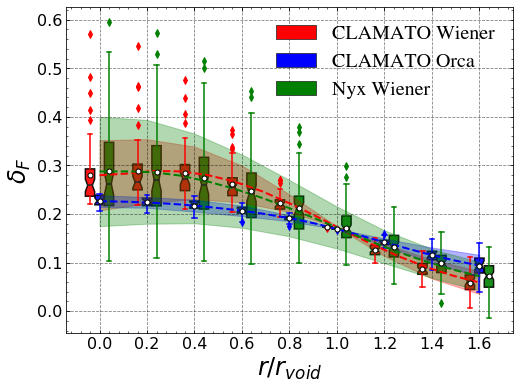

In [92]:
figure(figsize=(8,6))
ax = sns.boxplot(x="x", y="value", hue="method", data=mdf,palette=['red','blue','green'],width=0.6,saturation=1,
                 linewidth=1.5,notch=True,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"k",
                      "markersize":"5"})
fill_between(5*np.linspace(0,1.6,9),data_wiener.mean()-data_wiener.std(),data_wiener.mean()+data_wiener.std(),alpha=0.3,color='red')
fill_between(5*np.linspace(0,1.6,9),data_opt.mean()-data_opt.std(),data_opt.mean()+data_opt.std(),alpha=0.3,color='blue')
fill_between(5*np.linspace(0,1.6,9),data_nyx.mean()-data_nyx.std(),data_nyx.mean()+data_nyx.std(),alpha=0.3,color='green')
plot(5*x_wiener,y_wiener,color='red',ls='--',lw=2)
plot(5*x_opt,y_opt,color='blue',ls='--',lw=2)
plot(5*x_nyx,y_nyx,color='green',ls='--',lw=2)

legend(frameon=False,prop={'family':'STIXGeneral','size':20})
grid(linestyle="--", color="k",alpha=0.5)
ylabel(r'$\delta_F$',fontsize=24)
xlabel(r'$r/r_{void}$',fontsize=24)
tick_params(left='on',bottom='on',top='on', right='on', which='both',direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

xticks(fontsize=16)
yticks(fontsize=16)
for i,artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor('k')
    artist.set_alpha(0.9)
    for j in range(i*7,i*7+4):
        
        line = ax.lines[j]
        line.set_color(col)
    for j in range(i*7+4,i*7+7):
        line = ax.lines[j]
        line.set_mec(col)
        line.set_mfc(col)
        ax.lines[i*7+5].set_mec('k')
        ax.lines[i*7+5].set_mfc('white')

# ylim(-0.01,0.4)
savefig('clamato_profile.pdf',bbox_inches = 'tight')

In [103]:
coords_wiener_int,r_wiener_int=r_intersect2(coords_wiener,r_wiener)
coords_opt_int,r_opt_int=r_intersect(coords_opt,r_opt)

In [105]:
def format_func(value,ticks):
    return int(value/2)

In [107]:
rcParams['font.family']='STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'

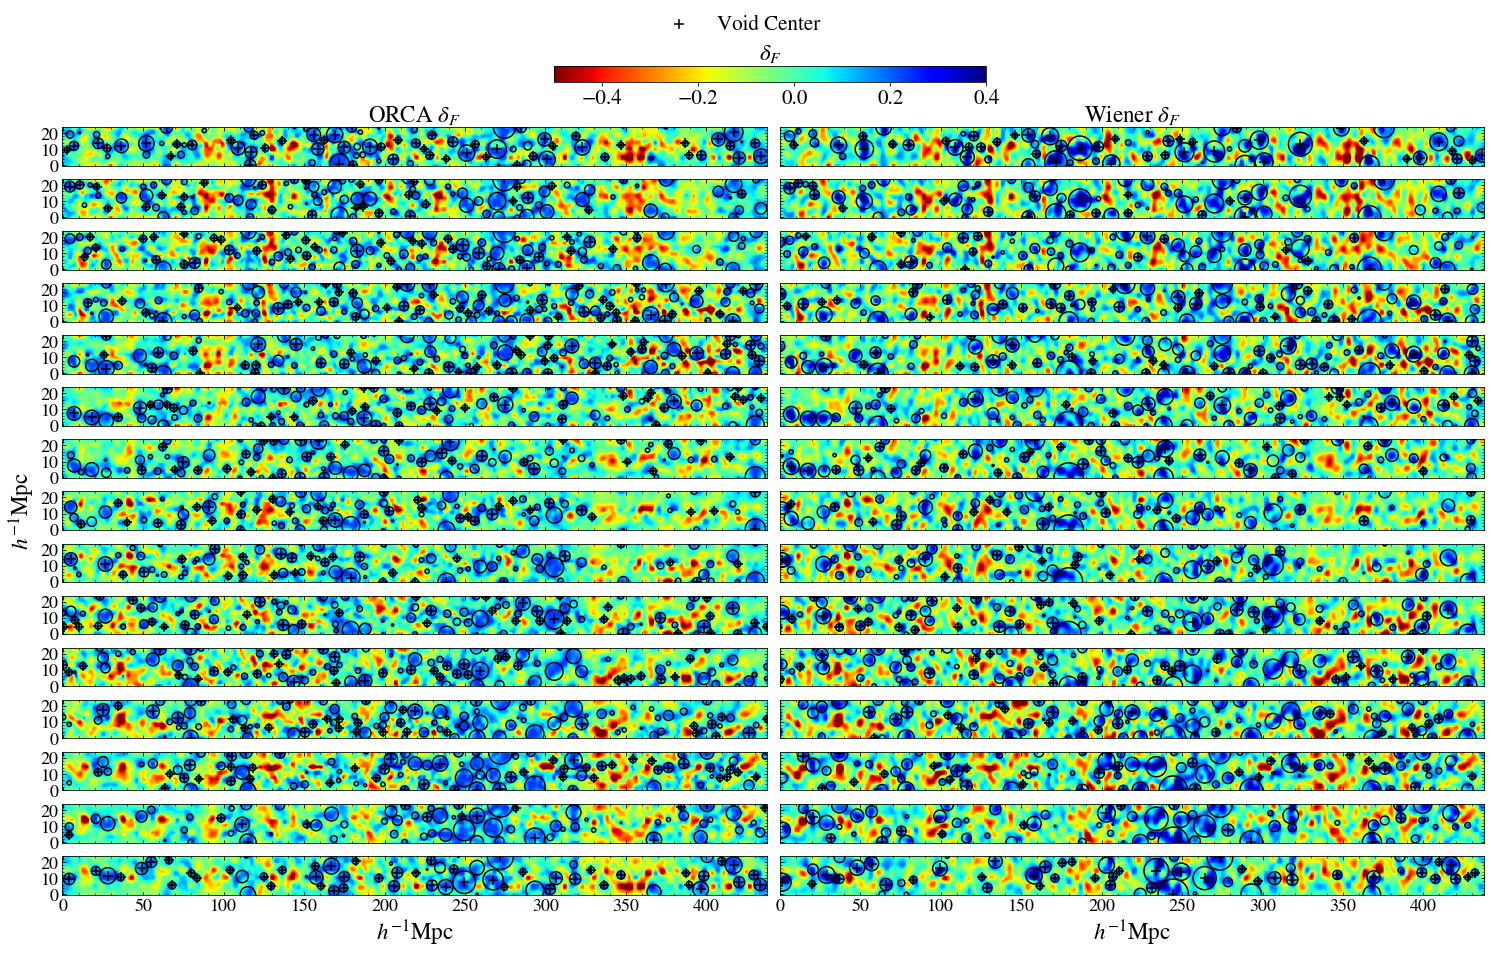

In [108]:
fig,ax = subplots(15,2,figsize=(20,11),sharex='col',sharey='row')
tight_layout(pad=0,h_pad=0,w_pad=0)

ii=0

for i in arange(57,0,-4):
    
    idx1 = where(coords_opt[:,2]==i)
    idx2 = where(coords_opt[:,2]==i+1)
    idx3 = where(coords_opt[:,2]==i+2)
    idx4 = where(coords_opt[:,2]==i-1)
    idx_c = append(append(append(array(idx1),array(idx2)),idx3),idx4)
    sc1 = ax[ii,0].scatter(coords_opt[:,0][idx_c],coords_opt[:,1][idx_c],marker='+',c='k',s=100)
    
    opt_avg = average(opt_contrast[:,:,i-1:i+2].T,axis=0)
    im = ax[ii,0].imshow(opt_avg,origin='lower',cmap='jet_r',vmin=-0.5,vmax=0.4)

    idx = array(where(coords_opt_int[:,2]==i))[0]
    
    ax[ii,0].yaxis.set_major_locator(plt.MultipleLocator(20))
    ax[ii,0].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax[ii,0].yaxis.set_minor_locator(MultipleLocator(4))
    ax[ii,0].tick_params(labelsize=18,left='on',bottom='on',top='on', right='on', which='both',direction='in')
    ax[ii,1].tick_params(labelsize=18,left='on',bottom='on',top='on', right='on', which='both',direction='in')
    for j,coords in enumerate(coords_opt_int[idx]):
        draw_circle = Circle((coords[0], coords[1]), radius=r_opt_int[idx[j]],fill=False,linewidth=1.5,color='k')
        ax[ii,0].add_artist(draw_circle)

    idx1 = where(coords_wiener[:,0]==i)
    idx2 = where(coords_wiener[:,0]==i+1)
    idx3 = where(coords_wiener[:,0]==i+2)
    idx4 = where(coords_wiener[:,0]==i-1)
    idx_c = append(append(append(array(idx1),array(idx2)),idx3),idx4)
    
    sc2 = ax[ii,1].scatter(coords_wiener[:,2][idx_c],coords_wiener[:,1][idx_c],marker='+',c='k',label='Void Center',s=100)
    
    wiener_avg = average(wiener_contrast[i-1:i+2,:,:],axis=0)
    im = ax[ii,1].imshow(wiener_avg,origin='lower',cmap='jet_r',vmin=-0.5,vmax=0.4)

    idx = array(where(coords_wiener_int[:,0]==i))[0]
    
    for j,coords in enumerate(coords_wiener_int[idx]):
        draw_circle = Circle((coords[2], coords[1]), radius=r_wiener_int[idx[j]],fill=False,linewidth=1.5,color='k')
        ax[ii,1].add_artist(draw_circle)

    ii+=1

legend(prop={'size':21},bbox_to_anchor=(0.07, 23), loc=1, borderaxespad=0,frameon=False)
position=fig.add_axes([0.35, 1.05, 0.3, 0.02])
cb=colorbar(im,position,orientation='horizontal') 
cb.ax.tick_params(labelsize=21)
title(r'$\delta_F$',size=23)
ax[14,0].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax[14,1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax[0,0].set_title('ORCA '+r'$\delta_F$',size=23)
ax[0,1].set_title('Wiener '+r'$\delta_F$',size=23)
ax[14,0].set_xlabel(r'$h^{-1}$'+'Mpc',{'size':23})
ax[14,1].set_xlabel(r'$h^{-1}$'+'Mpc',{'size':23})
ax[7,0].set_ylabel(r'$h^{-1}$'+'Mpc',{'size':23})

ax[14,0].xaxis.set_minor_locator(MultipleLocator(20))
ax[14,1].xaxis.set_minor_locator(MultipleLocator(20))

savefig('voids_compare.pdf',bbox_inches = 'tight')
show()

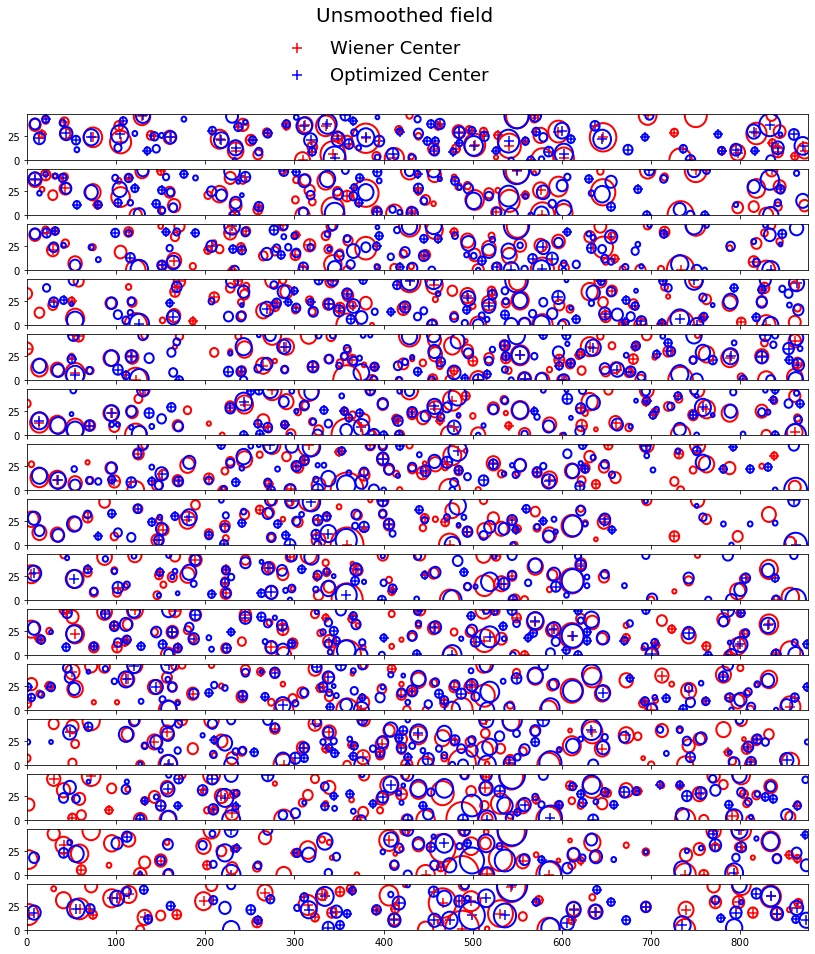

In [308]:
fig,ax = subplots(15,1,figsize=(14,15),sharex='col')

ii=0

for i in arange(57,0,-4):
    
    idx1 = where(coords_wiener[:,0]==i)
    idx2 = where(coords_wiener[:,0]==i+1)
    idx3 = where(coords_wiener[:,0]==i+2)
    idx4 = where(coords_wiener[:,0]==i-1)
    idx_c = append(append(append(array(idx1),array(idx2)),idx3),idx4)
    sc = ax[ii].scatter(coords_wiener[:,2][idx_c],coords_wiener[:,1][idx_c],marker='+',c='r',label='Wiener Center',s=100)
    idx = where(coords_wiener_int[:,0]==i)[0]

    for j,coords in enumerate(coords_wiener_int[idx]):
        draw_circle = Circle((coords[2], coords[1]), radius=r_wiener_int[idx[j]],fill=False,linewidth=2,label='Wiener',color='r')
        ax[ii].add_artist(draw_circle)
    
    idx1 = where(coords_opt[:,2]==i)
    idx2 = where(coords_opt[:,2]==i+1)
    idx3 = where(coords_opt[:,2]==i+2)
    idx4 = where(coords_opt[:,2]==i-1)
    idx_c = append(append(append(array(idx1),array(idx2)),idx3),idx4)
    sc = ax[ii].scatter(coords_opt[:,0][idx_c],coords_opt[:,1][idx_c],marker='+',c='b',label='Optimized Center',s=100)
    idx = where(coords_opt_int[:,2]==i)[0]

    for j,coords in enumerate(coords_opt_int[idx]):
        draw_circle = Circle((coords[0], coords[1]), radius=r_opt_int[idx[j]],fill=False,linewidth=2,label='Optimized',color='b')
        ax[ii].add_artist(draw_circle)
    ax[ii].set_xlim(0,876)
    ax[ii].set_ylim(0,48)
    ii+=1
legend()

legend(prop={'size':18},bbox_to_anchor=(0.6, 19.6), loc=1, borderaxespad=0,frameon=False)
suptitle('Unsmoothed field',fontsize=20)
show()